cuda
2.8.0+cu126
12.6
True

Using device: cuda

login success!
原始数据前5行:
    open   high    low  close      volume       amount      turn    pctChg
0  12.61  12.77  12.60  12.72  31323053.0  398614966.0  0.111455  1.032566
1  12.73  12.80  12.66  12.66  37839101.0  480954809.0  0.134641 -0.471701
2  12.70  12.73  12.62  12.66  27883804.0  353205838.0  0.099217  0.000000
3  12.67  12.71  12.62  12.69  31026744.0  393058250.0  0.110401  0.236965
4  12.69  12.71  12.63  12.68  31389887.0  397842209.0  0.111693 -0.078797
logout success!

变化率数据前5行:
[[ 1.26100000e+01  1.27700000e+01  1.26000000e+01  1.27200000e+01
   3.13230530e+07  3.98614966e+08  1.11455000e-01  0.00000000e+00]
 [ 9.51625694e-01  2.34925607e-01  4.76190476e-01 -4.71698113e-01
   2.08027232e+01  2.06564856e+01  1.34641000e-01 -4.71701000e-01]
 [-2.35663786e-01 -5.46875000e-01 -3.15955766e-01  0.00000000e+00
  -2.63095495e+01 -2.65615331e+01  9.92170000e-02  0.00000000e+00]
 [-2.36220472e-01 -1.57109191e-01  0.00000000e+00  2

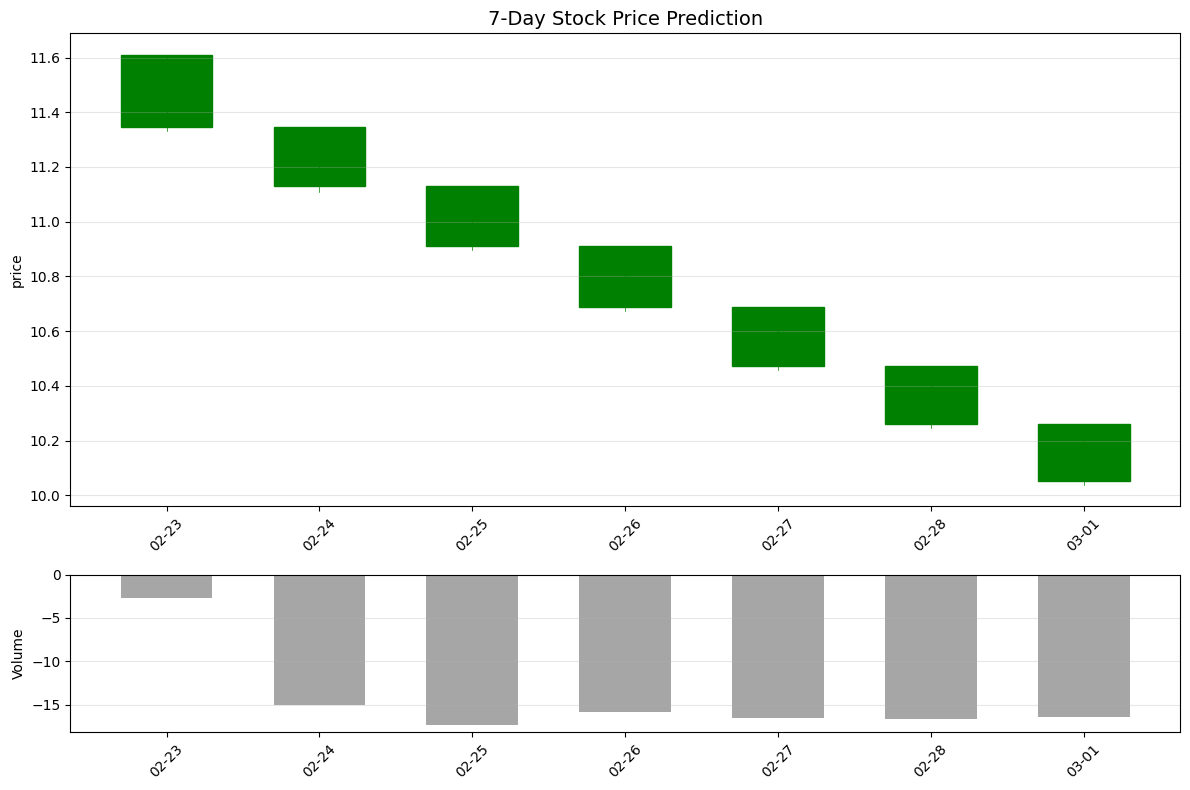

预测K线图:


AssertionError: Expected (7,8), got (7, 14)

In [ ]:
import torch
from torch import nn
import math
import numpy as np
import baostock as bs
import pandas as pd
import matplotlib.pyplot as plt
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mdates
from datetime import datetime, timedelta
from matplotlib.dates import DateFormatter, DayLocator, date2num
# pip install baostock mplfinance

# 配置参数
SEED = 42
LOOKBACK = 30
FORECAST = 7
BATCH_SIZE = 64

NUM_LAYERS = 2
NUM_HEADS = 2
D_MODEL = 256
D_FF = 512
DROPOUT = 0.5
LR = 0.0001
EPOCHS = 2000
PATIENCE = 100

# 损失函数权重 - 现在更简单，因为预测变化率自然会产生波动
val_coef = 1.0    # 最终价格准确性
vaild_coef = 5.0  # 价格合法性
vol_coef = 2.0    # 波动率匹配

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 设置随机种子
torch.random.manual_seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)

print(DEVICE)
print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())

# Transformer组件
class Embedding(nn.Module):
    def __init__(self, num_features, d_model):
        super(Embedding, self).__init__()
        self.linear = nn.Linear(num_features, d_model)

    def forward(self, x):
        x = self.linear(x)
        return x

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        encoding = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        encoding[:, 0::2] = torch.sin(position * div_term)
        encoding[:, 1::2] = torch.cos(position * div_term)
        encoding = encoding.unsqueeze(0)
        self.register_buffer('encoding', encoding)

    def forward(self, x):
        return x + self.encoding[:, :x.size(1), :]

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        self.drop = nn.Dropout(dropout)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        attn_weights = torch.softmax(attn_scores, dim=-1)
        attn_weights = self.drop(attn_weights)
        output = torch.matmul(attn_weights, V)
        return output

    def split_heads(self, x):
        batch_size, seq_len = x.size(0), x.size(1)
        x = x.view(batch_size, seq_len, self.num_heads, self.d_k)
        return x.transpose(1, 2)

    def combine_heads(self, x):
        batch_size, _, seq_len = x.size(0), x.size(1), x.size(2)
        x = x.transpose(1, 2)
        return x.contiguous().view(batch_size, seq_len, self.d_model)

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)
        Q = self.W_q(query)
        K = self.W_k(key)
        V = self.W_v(value)
        Q = self.split_heads(Q)
        K = self.split_heads(K)
        V = self.split_heads(V)
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        output = self.combine_heads(attn_output)
        output = self.W_o(output)
        return output

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(FeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.activation = nn.GELU()
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        return x

class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.feed_forward = FeedForward(d_model, d_ff)
        self.norm2 = nn.LayerNorm(d_model)
        self.drop = nn.Dropout(dropout)

    def forward(self, x):
        residual = x
        x = self.self_attn(x, x, x)
        x = self.drop(x)
        x = self.norm1(x + residual)
        residual = x
        x = self.feed_forward(x)
        x = self.drop(x)
        x = self.norm2(x + residual)
        return x

class Encoder(nn.Module):
    def __init__(self, num_feature, num_layers, d_model, num_heads, d_ff, dropout):
        super(Encoder, self).__init__()
        self.embedding = Embedding(num_feature, d_model)
        self.pos_encoding = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)
        ])
        self.drop = nn.Dropout(dropout)

    def forward(self, x):
        x = self.embedding(x)
        x = self.pos_encoding(x)
        x = self.drop(x)
        for layer in self.layers:
            x = layer(x)
        return x

class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads, dropout)
        self.norm2 = nn.LayerNorm(d_model)
        self.feed_forward = FeedForward(d_model, d_ff)
        self.norm3 = nn.LayerNorm(d_model)
        self.drop = nn.Dropout(dropout)

    def forward(self, x, encode_ouput, mask):
        residual = x
        x = self.self_attn(x, x, x, mask)
        x = self.drop(x)
        x = self.norm1(x + residual)
        residual = x
        x = self.enc_dec_attn(x, encode_ouput, encode_ouput)
        x = self.drop(x)
        x = self.norm2(x + residual)
        residual = x
        x = self.feed_forward(x)
        x = self.drop(x)
        x = self.norm3(x + residual)
        return x

class Decoder(nn.Module):
    def __init__(self, num_feature, num_layers, d_model, num_heads, d_ff, dropout):
        super(Decoder, self).__init__()
        self.embedding = Embedding(num_feature, d_model)
        self.pos_encoding = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)
        ])
        self.fc = nn.Linear(d_model, num_feature)
        self.drop = nn.Dropout(dropout)

    def forward(self, x, enc_output, mask):
        x = self.embedding(x)
        x = self.pos_encoding(x)
        x = self.drop(x)
        for layer in self.layers:
            x = layer(x, enc_output, mask)
        x = self.fc(x)
        return x

def create_look_ahead_mask(size, device=None):
    mask = torch.triu(torch.ones(size, size), diagonal=1).type(torch.uint8)
    mask = mask == 0
    if device is not None:
        mask = mask.to(device)
    return mask

def validity_loss(x):
    """
    计算预测结果的合法性损失
    """
    high = x[:, :, 1]  # 最高价变化率
    low = x[:, :, 2]   # 最低价变化率
    open_price = x[:, :, 0]  # 开盘价变化率
    close = x[:, :, 3]  # 收盘价变化率

    # 1. 检查价格变化是否合理（高价变化不应小于低价变化）
    low_high_violation = torch.relu(low - high)
    
    # 2. 开盘价和收盘价应该在最低价和最高价变化范围内
    open_bounds_violation = torch.relu(open_price - high) + torch.relu(low - open_price)
    close_bounds_violation = torch.relu(close - high) + torch.relu(low - close)
    
    # 3. 修正：价格变化不应过大（防止极端预测）
    # 取4个价格特征中变化最大的那个（绝对值）
    max_change = torch.max(torch.abs(x[:, :, :4]), dim=2)[0]
    # 使用50表示50%的变化限制（因为数据是百分比形式）
    extreme_change = torch.relu(max_change - 50.0)  

    total_violation = (
        10.0 * low_high_violation +
        5.0 * open_bounds_violation +
        5.0 * close_bounds_violation +
        3.0 * extreme_change
    )
    
    return total_violation.mean()

def infer(encoder, decoder, inputs, original_df, start_idx, infer_steps):
    """
    inputs: [1, seq_len, num_features]
    original_df: 原始DataFrame用于获取基准价格
    start_idx: 输入序列在原始数据中的起始索引
    results: [infer_steps, num_features]
    """
    encoder.eval()
    decoder.eval()
    
    # 获取模型所在的设备
    device = next(encoder.parameters()).device
    
    # 确保输入数据在正确的设备上
    inputs = inputs.to(device)
    results = []
    
    # 获取基准价格（输入序列的最后一天的原始价格）
    base_idx = start_idx + inputs.size(1) - 1
    base_prices = original_df.iloc[base_idx][['open', 'high', 'low', 'close']].values.astype(float)
    base_open = base_prices[0]
    base_high = base_prices[1]
    base_low = base_prices[2]
    base_close = base_prices[3]
    
    with torch.no_grad():
        shift_outputs = inputs[:, -1:, :].clone()
        
        encode = encoder(inputs)
        for step in range(infer_steps):
            mask_size = shift_outputs.size(1)
            mask = create_look_ahead_mask(mask_size, device)
            
            decode = decoder(shift_outputs, encode, mask)
            
            # 获取预测的变化率
            pred_changes = decode[:, -1, :].cpu().numpy()[0]
            
            # 复原实际价格
            if step == 0:
                # 第一天使用基准价格
                pred_open = base_open
            else:
                # 后续天使用前一天的收盘价
                pred_open = results[-1][3]
            
            # 计算当天的OHLC
            pred_high = pred_open * (1 + pred_changes[1] / 100)
            pred_low = pred_open * (1 + pred_changes[2] / 100)
            pred_close = pred_open * (1 + pred_changes[3] / 100)
            
            # 确保价格关系合理
            pred_high = max(pred_high, pred_open, pred_close)
            pred_low = min(pred_low, pred_open, pred_close)
            
            # 保存复原后的价格
            restored = np.array([
                pred_open, pred_high, pred_low, pred_close,
                *pred_changes[4:]  # 其他特征直接使用预测值
            ])
            
            results.append(restored)
            
            # 为下一次预测准备输入
            # 创建新的变化率输入（相对于前一天）
            if step == 0:
                # 第一天的变化率是相对于基准日
                new_input = np.zeros_like(pred_changes)
                new_input[0] = (pred_open - base_open) / base_open * 100
                new_input[1] = (pred_high - base_open) / base_open * 100
                new_input[2] = (pred_low - base_open) / base_open * 100
                new_input[3] = (pred_close - base_open) / base_open * 100
                new_input[4:] = pred_changes[4:]
            else:
                # 后续天的变化率是相对于前一天
                prev_open = results[-2][0]
                new_input = np.zeros_like(pred_changes)
                new_input[0] = (pred_open - prev_open) / prev_open * 100
                new_input[1] = (pred_high - prev_open) / prev_open * 100
                new_input[2] = (pred_low - prev_open) / prev_open * 100
                new_input[3] = (pred_close - prev_open) / prev_open * 100
                new_input[4:] = pred_changes[4:]
            
            # 添加到shift_outputs
            new_input_tensor = torch.tensor(new_input, dtype=torch.float32, device=device).unsqueeze(0).unsqueeze(0)
            shift_outputs = torch.cat((shift_outputs, new_input_tensor), dim=1)

    return torch.tensor(np.array(results), device=device, dtype=torch.float32)

def prepare_data(data, lookback, forecast):
    """
    准备训练数据
    注意：data已经是变化率数据，不是原始价格
    """
    X, y = [], []
    # 从lookback开始，确保有足够历史数据
    for i in range(lookback, len(data) - forecast):
        # X是lookback天的变化率序列
        X.append(data[i-lookback+1:i+1])
        # y是接下来forecast天的变化率
        y.append(data[i+1:i+1+forecast])
    return np.array(X), np.array(y)

def fetch_data_loader():
    bs.login()
    rs = bs.query_history_k_data_plus("sh.600000",
        "date,code,open,high,low,close,preclose,volume,amount,adjustflag,turn,tradestatus,pctChg,isST",
        start_date='2018-01-01', end_date='2024-12-31',
        frequency="d", adjustflag="3")
    
    data_list = []
    while (rs.error_code == '0') & rs.next():
        data_list.append(rs.get_row_data())
    
    df = pd.DataFrame(data_list, columns=rs.fields)
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(by='date')
    df = df.reset_index(drop=True)
    
    # 保存日期列用于后续绘图
    date_series = df['date'].copy()
    
    # 保留'date'列在original_df中，但不用于模型输入
    original_df = df.copy()
    
    # 用于模型的特征列（不包含'date'）
    feature_columns = ['open', 'high', 'low', 'close', 'volume', 'amount', 'turn', 'pctChg']
    df = df[feature_columns]
    df = df.astype(float)
    
    print("原始数据前5行:")
    print(df.head())

    bs.logout()
    
    from sklearn.model_selection import train_test_split
    from torch.utils.data import DataLoader, TensorDataset
    
    # 关键修改：计算价格变化率而不是使用绝对价格
    data = df.values
    transformed_data = np.zeros_like(data)
    
    # 保留第一天的原始数据作为基准
    transformed_data[0] = data[0]
    
    # 计算每天相对于前一天的变化率（百分比）
    for i in range(1, len(data)):
        # 价格列: 计算变化率 (相对变化)
        for j in [0, 1, 2, 3]:  # open, high, low, close
            transformed_data[i, j] = (data[i, j] - data[i-1, j]) / data[i-1, j] * 100
        
        # 成交量列: 计算变化率
        for j in [4, 5]:  # volume, amount
            transformed_data[i, j] = (data[i, j] - data[i-1, j]) / (data[i-1, j] + 1e-8) * 100
        
        # 换手率和涨跌幅直接使用
        transformed_data[i, 6] = data[i, 6]  # turn
        transformed_data[i, 7] = data[i, 7]  # pctChg
    
    # 填充第一天的涨跌幅为0 (没有前一天数据)
    transformed_data[0, 7] = 0
    
    print("\n变化率数据前5行:")
    print(transformed_data[:5])
    
    # 准备训练数据
    X, y = prepare_data(transformed_data, LOOKBACK, FORECAST)
    
    # 划分训练集和验证集
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=SEED, shuffle=False)
    
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)
    X_val = torch.tensor(X_val, dtype=torch.float32)
    y_val = torch.tensor(y_val, dtype=torch.float32)
    
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    return train_loader, val_loader, original_df, date_series

def get_loss(predicted, target):
    """简化损失函数 - 预测变化率自然会产生波动"""
    # 基本损失：预测变化率与目标变化率的差异
    change_loss = nn.functional.mse_loss(predicted, target)
    
    # 价格合法性损失
    vaild_loss = validity_loss(predicted)
    
    # 波动率匹配损失
    pred_close = predicted[:, :, 3]  # 预测的收盘价变化率
    target_close = target[:, :, 3]   # 目标收盘价变化率
    
    # 计算预测和目标的波动率
    pred_volatility = torch.std(pred_close, dim=1)
    target_volatility = torch.std(target_close, dim=1)
    
    # Huber损失匹配波动率
    vol_loss = nn.functional.huber_loss(pred_volatility, target_volatility, reduction='mean')
    
    # 组合损失
    total_loss = (val_coef * change_loss +
                  vaild_coef * vaild_loss +
                  vol_coef * vol_loss)
    
    return total_loss, change_loss, vaild_loss, vol_loss

def train(encoder, decoder, train_loader, val_loader, lr, epochs, patience):
    """训练函数"""
    encoder.to(DEVICE)
    decoder.to(DEVICE)
    
    params = list(encoder.parameters()) + list(decoder.parameters())
    optimizer = torch.optim.Adam(params, lr=lr)
    
    # 早停机制相关变量
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = {
        'encoder': None,
        'decoder': None,
        'epoch': -1,
        'val_loss': float('inf')
    }
    
    for epoch in range(epochs):
        encoder.train()
        decoder.train()
        train_loss = 0
        train_change_loss = 0
        train_vaild_loss = 0
        train_vol_loss = 0
        
        for train_x, train_y in train_loader:
            train_x, train_y = train_x.to(DEVICE), train_y.to(DEVICE)
            
            optimizer.zero_grad()
            
            enc_output = encoder(train_x)
            
            mask_size = train_y.size(1)
            mask = create_look_ahead_mask(mask_size, DEVICE)
            
            decoder_input = torch.cat([train_x[:, -1:, :], train_y[:, :-1, :]], dim=1)
            
            dec_output = decoder(decoder_input, enc_output, mask)
            
            # 组合损失
            loss, change_loss, vaild_loss, vol_loss = get_loss(dec_output, train_y)
            loss.backward()
            
            # 添加梯度裁剪，防止梯度爆炸
            torch.nn.utils.clip_grad_norm_(params, max_norm=1.0)
            
            optimizer.step()
            
            train_loss += loss.item()
            train_change_loss += change_loss.item()
            train_vaild_loss += vaild_loss.item()
            train_vol_loss += vol_loss.item()
        
        train_avg_loss = train_loss / len(train_loader)
        train_avg_change_loss = train_change_loss / len(train_loader)
        train_avg_vaild_loss = train_vaild_loss / len(train_loader)
        train_avg_vol_loss = train_vol_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{epochs}], Total Loss: {train_avg_loss:.4f}, Change Loss: {train_avg_change_loss:.4f}, "
              f"Valid Loss: {train_avg_vaild_loss:.4f}, Vol Loss: {train_avg_vol_loss:.4f}")
        
        # Validation
        encoder.eval()
        decoder.eval()
        val_loss = 0
        val_change_loss = 0
        val_vaild_loss = 0
        val_vol_loss = 0
        with torch.no_grad():
            for val_x, val_y in val_loader:
                val_x, val_y = val_x.to(DEVICE), val_y.to(DEVICE)
                
                enc_output = encoder(val_x)
                
                mask_size = val_y.size(1)
                mask = create_look_ahead_mask(mask_size, DEVICE)
                
                decoder_input = torch.cat([val_x[:, -1:, :], val_y[:, :-1, :]], dim=1)
                
                dec_output = decoder(decoder_input, enc_output, mask)
                
                # 组合损失
                loss, change_loss, vaild_loss, vol_loss = get_loss(dec_output, val_y)
                
                val_loss += loss.item()
                val_change_loss += change_loss.item()
                val_vaild_loss += vaild_loss.item()
                val_vol_loss += vol_loss.item()
                
        val_avg_loss = val_loss / len(val_loader)
        val_avg_change_loss = val_change_loss / len(val_loader)
        val_avg_vaild_loss = val_vaild_loss / len(val_loader)
        val_avg_vol_loss = val_vol_loss / len(val_loader)
        print(f"Val - Total Loss: {val_avg_loss:.4f}, Change Loss: {val_avg_change_loss:.4f}, "
              f"Valid Loss: {val_avg_vaild_loss:.4f}, Vol Loss: {val_avg_vol_loss:.4f}")
        
        # 早停机制检查
        if val_avg_loss < best_val_loss:
            best_val_loss = val_avg_loss
            patience_counter = 0
            # 保存最佳模型状态
            best_model_state = {
                'encoder': encoder.state_dict().copy(),
                'decoder': decoder.state_dict().copy(),
                'epoch': epoch,
                'val_loss': val_avg_loss
            }
            print(f"Validation loss improved to {val_avg_loss:.4f}, saving model...")
        else:
            patience_counter += 1
            print(f"Validation loss did not improve. Patience: {patience_counter}/{patience}")
        
        # 检查是否应该早停
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs. Best validation loss: {best_val_loss:.4f}")
            # 恢复最佳模型
            encoder.load_state_dict(best_model_state['encoder'])
            decoder.load_state_dict(best_model_state['decoder'])
            break
    
    # 如果没有早停，确保最后保存的是最佳模型
    if patience_counter < patience:
        encoder.load_state_dict(best_model_state['encoder'])
        decoder.load_state_dict(best_model_state['decoder'])
        print(f"Training completed. Best validation loss: {best_val_loss:.4f} at epoch {best_model_state['epoch']+1}")

def plot_kline(predictions, start_date=None):
    """
    绘制7天K线图
    """
    # 验证输入
    assert predictions.shape == (7, 8), f"Expected (7,8), got {predictions.shape}"
    
    ohlc = predictions[:, :4]  # open, high, low, close
    volume = predictions[:, 4]  # volume
    
    # 处理日期
    if start_date is None:
        start_date = datetime.now()
    else:
        start_date = datetime.strptime(start_date, "%Y-%m-%d")
    
    # 只保留日期，去除时间部分
    start_date = start_date.replace(hour=0, minute=0, second=0, microsecond=0)
    dates = [start_date + timedelta(days=i) for i in range(7)]
    
    EPS = 1e-5  # 容差，防止浮点误差误报
    
    for i in range(7):
        o, h, l, c = ohlc[i]
        
        if h < l - EPS:
            print(f"警告: high < low [H={h:.4f}, L={l:.4f}]")
        elif o < l - EPS or o > h + EPS:
            print(f"警告: open 超出 [low, high] 范围 [O={o:.4f}, L={l:.4f}, H={h:.4f}]")
        elif c < l - EPS or c > h + EPS:
            print(f"警告: close 超出 [low, high] 范围 [C={c:.4f}, L={l:.4f}, H={h:.4f}]")
    
    # 准备 OHLC 数据
    ohlc_data = [
        [date2num(date), o, h, l, c]
        for date, (o, h, l, c) in zip(dates, ohlc)
    ]
    
    # 创建子图
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'height_ratios': [3, 1]})
    
    # 绘制 K 线
    candlestick_ohlc(ax1, ohlc_data, width=0.6, colorup='red', colordown='green')
    ax1.set_title('7-Day Stock Price Prediction', fontsize=14)
    ax1.set_ylabel('price')
    ax1.xaxis.set_major_formatter(DateFormatter('%m-%d'))
    ax1.xaxis.set_major_locator(DayLocator())
    ax1.grid(True, axis='y', alpha=0.3)
    
    # 旋转标签
    for label in ax1.xaxis.get_majorticklabels():
        label.set_rotation(45)
    
    # 绘制成交量
    ax2.bar([date2num(date) for date in dates], volume, width=0.6, color='gray', alpha=0.7)
    ax2.set_ylabel('Volume')
    ax2.xaxis.set_major_formatter(DateFormatter('%m-%d'))
    ax2.xaxis.set_major_locator(DayLocator())
    ax2.grid(True, axis='y', alpha=0.3)
    
    for label in ax2.xaxis.get_majorticklabels():
        label.set_rotation(45)
    
    plt.tight_layout()
    plt.show()

# 在训练前添加设备检查
print(f"\n{'='*50}")
print(f"Using device: {DEVICE}")
print(f"{'='*50}\n")

# 获取数据 - 现在返回date_series
train_loader, val_loader, original_df, date_series = fetch_data_loader()

# 获取特征数量
num_features = train_loader.dataset[0][0].shape[-1]

# 初始化模型
encoder = Encoder(num_features, NUM_LAYERS, D_MODEL, NUM_HEADS, D_FF, DROPOUT)
decoder = Decoder(num_features, NUM_LAYERS, D_MODEL, NUM_HEADS, D_FF, DROPOUT)

# 训练模型
train(encoder, decoder, train_loader, val_loader, lr=LR, epochs=EPOCHS, patience=PATIENCE)

# 示例推理
sample_idx = 3
sample_input, sample_output = val_loader.dataset[sample_idx]
sample_input = sample_input.unsqueeze(0)  # 添加批次维度

# 计算原始数据中的起始索引
start_idx = sample_idx + LOOKBACK - 1

# 确保模型在正确的设备上
encoder.to(DEVICE)
decoder.to(DEVICE)
sample_input = sample_input.to(DEVICE)

# 使用修改后的推理函数
predictions = infer(encoder, decoder, sample_input, original_df, start_idx, FORECAST)

# 获取对应的原始目标数据（用于比较）
target_data = original_df.iloc[start_idx+1:start_idx+1+FORECAST].values

# 获取开始日期（从date_series中获取）
start_date = date_series.iloc[start_idx+1].strftime('%Y-%m-%d')

# 打印预测结果
print("\n预测结果 (复原后的价格):")
print(predictions.cpu().numpy())

print("\n实际结果 (原始数据):")
print(target_data)

# 绘制K线图
plot_kline(predictions.cpu().numpy(), start_date=start_date)
print("预测K线图:")
plot_kline(target_data, start_date=start_date)
print("实际K线图:")